# How long is a day?
In this tutorial we will use an astronomical Python library to show how the length of a day varies during one year. Let's start from importing the **ephem** module and instantiating an observer:

In [1]:
import ephem
observer = ephem.Observer()

To set observer's localization we have to set the position on the Earth's surface:

In [2]:
observer.lat = "51.109454"
observer.lon = "17.032686"
observer.elev = 120
observer

<ephem.Observer date='2017/10/22 13:17:09' epoch='2000/1/1 12:00:00' lon='17:01:57.7' lat='51:06:34.0' elevation=120.0m horizon=0:00:00.0 temp=15.0C pressure=1010.0mBar>

We can see that the observer is related with a date when the object was created. We need all days in one year, so a good choice is to use the **pandas** module and its fixed frequency datetime index for the current year:

In [3]:
import pandas as pd

current_year = observer.date.triple()[0]
all_days = pd.date_range(str(current_year) + "/01/01", str(current_year) + "/12/31")
all_days

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', length=365, freq='D')

To calculate the length of a specific day we have to estimate time between the Sun rising and setting:

In [4]:
sun = ephem.Sun()
day_length = []

for ad in all_days:
    observer.date = ad
    day_length += [observer.next_setting(sun) - observer.next_rising(sun)]
    
days = 24.*pd.DataFrame(day_length, index=all_days, columns=["day_length"])
days.head()

,day_length
2017-01-01,8.017117
2017-01-02,8.037027
2017-01-03,8.058562
2017-01-04,8.081697
2017-01-05,8.106407


It's time to visualize obtained results. To do this we will use the **matplotlib** library:

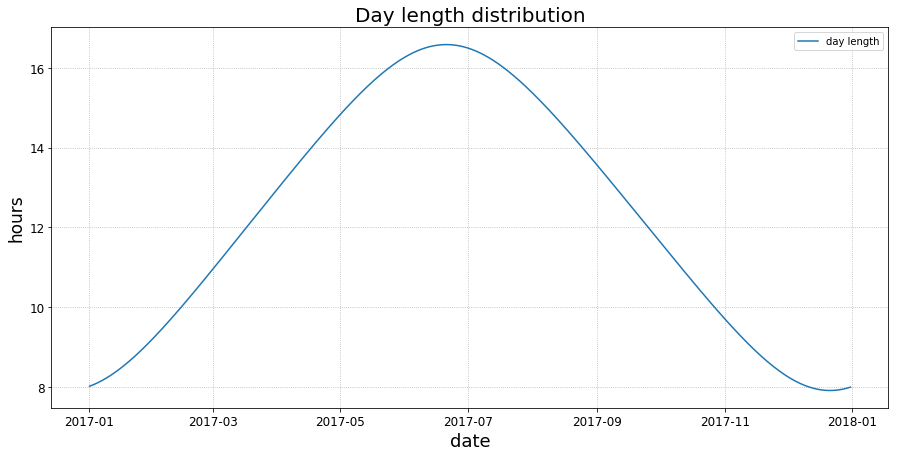

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,7))
plt.plot(days.index, days.values)
plt.title('Day length distribution', fontsize=20)
plt.xlabel('date', fontsize=18)
plt.ylabel('hours', fontsize=17)
plt.tick_params(labelsize=12)
plt.grid(linestyle='dotted')
plt.legend(('day length',))
plt.show()

We can see that the curve increases and decreases the most rapidly around both equinoxes. It means that people can notice changes of the day length week-by-week. There is additional interesting feature on the plot. Let's draw a similar function for nights. We know that a day lasts 24 hours, so we can quickly compute the length of each night:

In [6]:
days["night_length"] = 24. - days["day_length"]
days.head(3)

,day_length,night_length
2017-01-01,8.017117,15.982883
2017-01-02,8.037027,15.962973
2017-01-03,8.058562,15.941438


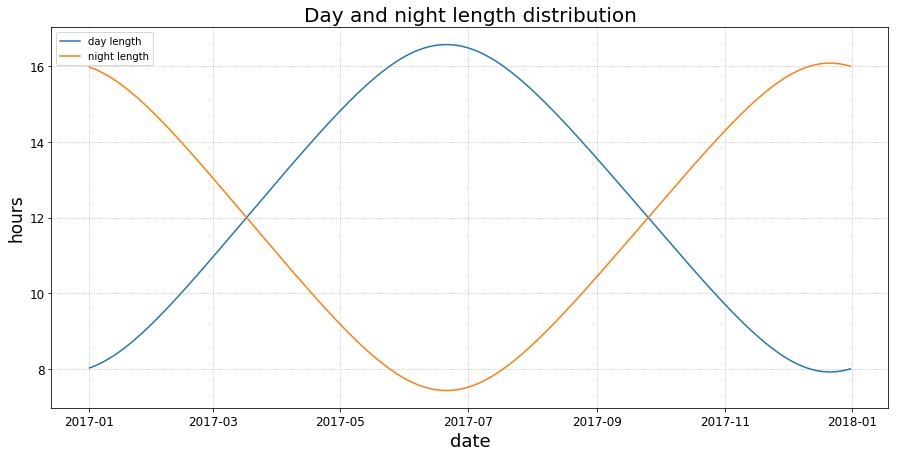

In [7]:
plt.figure(figsize=(15,7))
plt.title('Day and night length distribution', fontsize=20)
plt.plot(days.index, days["day_length"])
plt.plot(days.index, days["night_length"])
plt.xlabel('date', fontsize=18)
plt.ylabel('hours', fontsize=17)
plt.tick_params(labelsize=12)
plt.grid(linestyle='dotted')
plt.legend(('day length','night length'))
plt.show()

We see that the longest day is longer than the longest night. Let's sum the lengths of days and nights and compare their difference:

In [8]:
sum_diff = (days["day_length"].sum() - days["night_length"].sum())/24. # in days
sum_diff

8.6215135094535071

Intuitively it seems that the length of all days and all nights should be equal because the Earth's movements are symmetrical. As we can see it's not true. This phenomenon is mainly caused by atmospheric refraction which shifts up a position of the Sun near the horizon. Additional contribution comes from the fact that the Sun isn't a point but an extended source. Sunset and sunrise are defined as the moments when the upper limb of the Sun passes the horizon line rather than the geometric center of this body. Let's switch off refraction and define sunrise and sunset as a moment when the center of the Sun crosses the horizon:

In [9]:
day_length_mod = []

for ad in all_days:
    sun.compute(ad)
    observer.date = ad
    observer.pressure = 0 # remove atmospheric refraction
    observer.horizon = sun.radius # center point instead of the upper limb of the Sun
    day_length_mod += [observer.next_setting(sun) - observer.next_rising(sun)]
    
days_mod = 24.*pd.DataFrame(day_length_mod, index=all_days, columns=["day_length"])
days_mod["night_length"] = 24. - days_mod["day_length"]
days_mod.head(3)

,day_length,night_length
2017-01-01,7.777360,16.222640
2017-01-02,7.797804,16.202196
2017-01-03,7.819913,16.180087


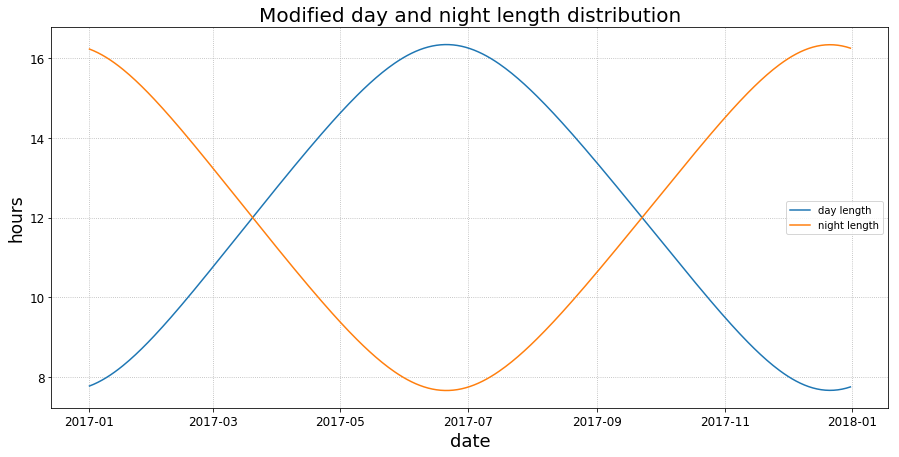

In [10]:
plt.figure(figsize=(15,7))
plt.title('Modified day and night length distribution', fontsize=20)
plt.plot(days_mod.index, days_mod["day_length"])
plt.plot(days_mod.index, days_mod["night_length"])
plt.xlabel('date', fontsize=18)
plt.ylabel('hours', fontsize=17)
plt.tick_params(labelsize=12)
plt.grid(linestyle='dotted')
plt.legend(('day length','night length'))
plt.show()

It seems to be better. Let's check the difference between the days and nights length sums:

In [11]:
sum_diff_mod = (days_mod["day_length"].sum() - days_mod["night_length"].sum())/24. # in days
sum_diff_mod

2.1328513289045077

Sums of all days and nights are not still equal (`sum_diff_mod = 0`). We've mentioned that the Earth's movements should be symmetrical. Let's check whether it is truth. At the beginning we consider the movement of Earth around the Sun:

In [12]:
dist = []

for ad in all_days:
    sun.compute(ad)
    dist += [sun.earth_distance] # in AU
    
distance = pd.DataFrame(dist, index=all_days, columns=["distance_to_sun"])
distance.head(3)

,distance_to_sun
2017-01-01,0.983338
2017-01-02,0.983324
2017-01-03,0.983315


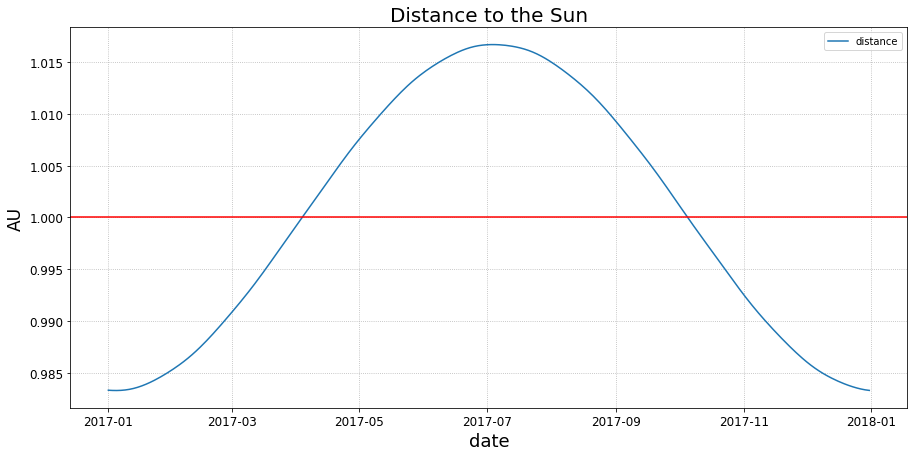

In [13]:
plt.figure(figsize=(15,7))
plt.title('Distance to the Sun', fontsize=20)
plt.plot(distance.index, distance["distance_to_sun"])
plt.axhline(y=1.0, color='r', linestyle='-')
plt.xlabel('date', fontsize=18)
plt.ylabel('AU', fontsize=17)
plt.tick_params(labelsize=12)
plt.grid(linestyle='dotted')
plt.legend(('distance',))
plt.show()

We clearly see that the distance varies during one year. This is caused by the fact that the Earth's orbit is an ellipse, not a circle. According to the second Kepler's law the velocity of Earth changes on its orbit. It implies that the Sun on the sky moves slower and faster - we assume that the angular velocity of Earth is constant. The second reason is that the Earth's rotation axis isn't perpendicular to the orbit plane. It's hard to eliminate both phenomenons using Python. Nevertheless they give smaller contribution than mechanisms described above. At the end let's check how the day length depends on latitude:

In [14]:
# restore standard values
observer.horizon = "00:00:00"
observer.pressure = 1010

latitude_step = 10
day_length_latitude = []
days_length_latitude = pd.DataFrame(index=all_days)

for lat in range(-90, 90 + latitude_step, latitude_step):
    day_length_latitude = []
    for ad in all_days:
        observer.lat = str(lat)
        observer.date = ad
        try:
            day_length_latitude += [observer.next_setting(sun) - observer.next_rising(sun)]
        except ephem.NeverUpError:
            day_length_latitude += [0]
            continue
        except ephem.AlwaysUpError:
            day_length_latitude += [1]
            continue
            
    days_length_latitude[lat] = 24.*pd.DataFrame(day_length_latitude, index=all_days)
    
days_length_latitude.head()

,-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80,90
2017-01-01,24.0,24.0,24.0,18.690607,16.283061,14.962244,14.046268,13.326121,12.706726,12.132876,11.563739,10.959504,10.268710,9.405805,8.189673,6.077698,0.0,0.0,0.0
2017-01-02,24.0,24.0,24.0,18.652380,16.263071,14.949322,14.037690,13.320777,12.704096,12.132741,11.566089,10.964535,10.276900,9.418165,8.208569,6.111480,0.0,0.0,0.0
2017-01-03,24.0,24.0,24.0,18.611220,16.241453,14.935333,14.028400,13.314989,12.701247,12.132595,11.568634,10.969984,10.285771,9.431545,8.229010,6.147914,0.0,0.0,0.0
2017-01-04,24.0,24.0,24.0,18.567215,16.218231,14.920290,14.018406,13.308761,12.698181,12.132436,11.571373,10.975848,10.295314,9.445935,8.250973,6.186935,0.0,0.0,0.0
2017-01-05,24.0,24.0,24.0,18.520455,16.193433,14.904210,14.007718,13.302098,12.694901,12.132267,11.574304,10.982120,10.305521,9.461321,8.274435,6.228475,0.0,0.0,0.0


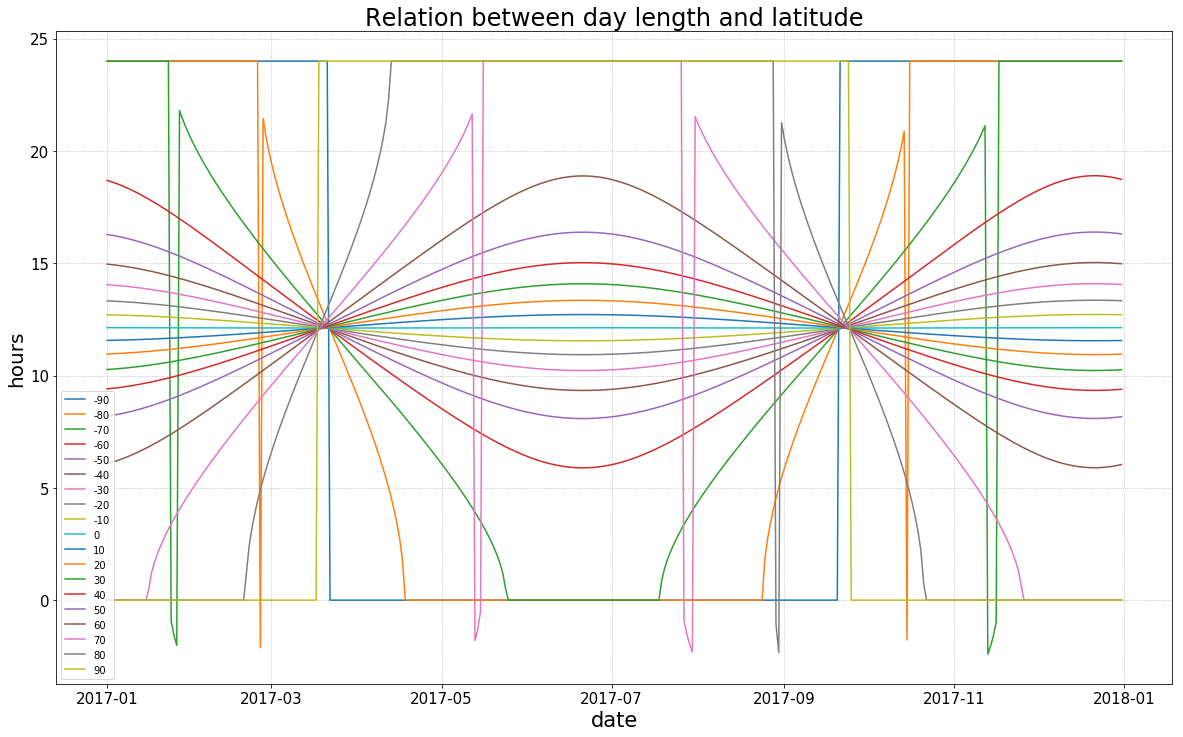

In [15]:
def plot_day_length_latitude(dataframe, step):
    plt.figure(figsize=(20,12))
    plt.title('Relation between day length and latitude', fontsize=24)

    for lat in range(-90, 90 + step, step):
        plt.plot(dataframe[lat].index, dataframe[lat])
    
    plt.xlabel('date', fontsize=21)
    plt.ylabel('hours', fontsize=20)
    plt.tick_params(labelsize=15)
    plt.grid(linestyle='dotted')
    plt.legend(tuple([str(d) for d in dataframe]))
    plt.show()
    
plot_day_length_latitude(days_length_latitude, latitude_step)

We see that something went wrong. There are unrealistic values less than zero. It's a numerical problem. In the last step we'll identify it and try to fix. Please, note that a negative value occurs for `lat=70` around the end of July:

In [16]:
latitude_causing_error = 70
days_length_latitude[latitude_causing_error][205:215]

2017-07-25    24.000000
2017-07-26    24.000000
2017-07-27    -0.898425
2017-07-28    -1.510566
2017-07-29    -1.947022
2017-07-30    -2.309578
2017-07-31    21.530003
2017-08-01    21.224989
2017-08-02    20.945058
2017-08-03    20.683797
Freq: D, Name: 70, dtype: float64

In [17]:
days_slice = days_length_latitude[latitude_causing_error][207:215].index
latitude_causing_error_string = str(latitude_causing_error)

for ds in days_slice:
    observer.lat = latitude_causing_error_string
    observer.date = ds
    setting = observer.next_setting(sun)
    rising = observer.next_rising(sun)
    print('%20s %20s %10.3f h' % (setting, rising, 24.*(setting - rising)))

  2017/7/27 22:31:53   2017/7/27 23:25:48     -0.898 h
  2017/7/28 22:13:31   2017/7/28 23:44:09     -1.511 h
  2017/7/29 22:00:24   2017/7/29 23:57:13     -1.947 h
  2017/7/30 21:49:29   2017/7/31 00:08:03     -2.310 h
  2017/7/31 21:39:51   2017/7/31 00:08:03     21.530 h
   2017/8/1 21:31:06    2017/8/1 00:17:36     21.225 h
   2017/8/2 21:22:57    2017/8/2 00:26:15     20.945 h
   2017/8/3 21:15:17    2017/8/3 00:34:15     20.684 h


Our observer was set at midnight. We assumed that time elapsing from midnight to sunrise is always shorter than the time period between midnight and sunset. We see that is not true. Because sunrise crosses midnight (`23:25:48 <- 00:00:00`) or jumps to the next day (`2017/7/30 21:49:29 -> 2017/7/31 00:08:03`) we have to handle these special cases:

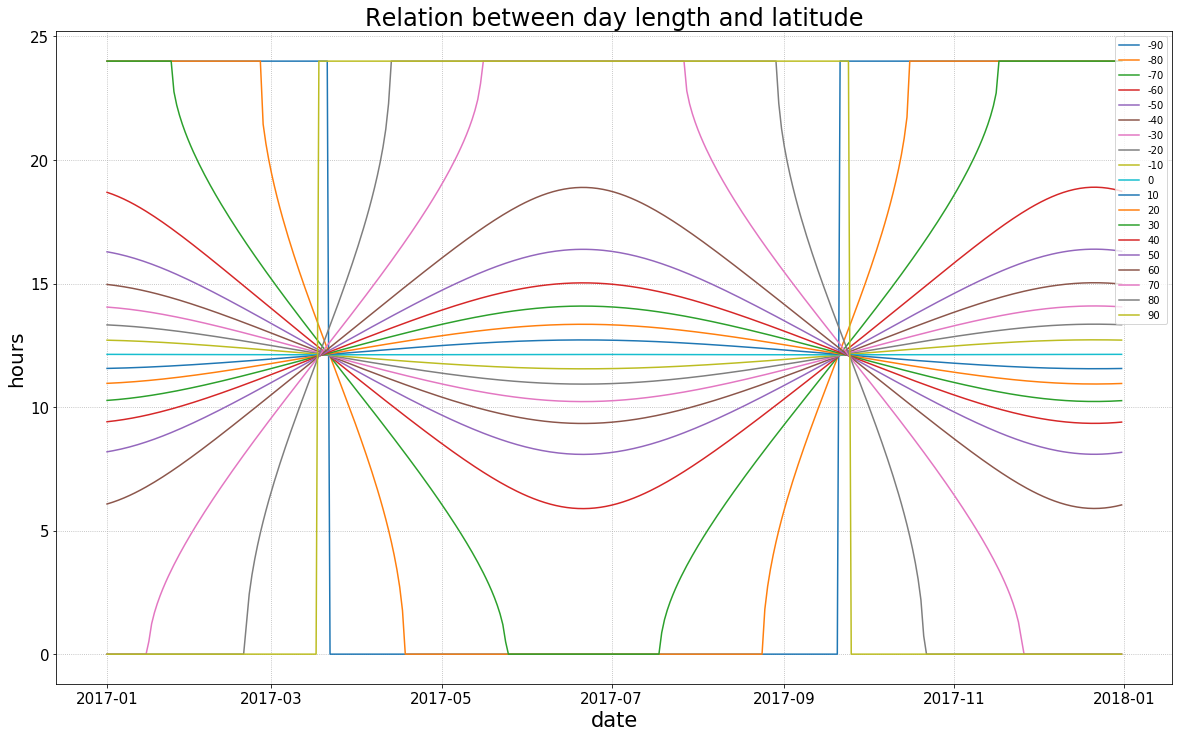

In [18]:
day_length_latitude_correct = []
days_length_latitude_correct = pd.DataFrame(index=all_days)

for lat in range(-90, 90 + latitude_step, latitude_step):
    day_length_latitude_correct = []
    for ad in all_days:
        observer.lat = str(lat)
        observer.date = ad
        try:
            current_day_length = observer.next_setting(sun) - observer.next_rising(sun)
            
            if current_day_length < 0: # special case
                day_length_latitude_correct += [observer.next_setting(sun) - observer.previous_rising(sun)]
            else:
                day_length_latitude_correct += [current_day_length]
                
        except ephem.NeverUpError:
            day_length_latitude_correct += [0]
            continue
        except ephem.AlwaysUpError:
            day_length_latitude_correct += [1]
            continue
            
    days_length_latitude_correct[lat] = 24.*pd.DataFrame(day_length_latitude_correct, index=all_days)
    
plot_day_length_latitude(days_length_latitude_correct, latitude_step)